In [47]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from functions import *
from IPython.display import HTML
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
%matplotlib inline

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

In [48]:
# Read in cars and notcars dataset
cars = glob.glob('dataset/cars/**/*.png')
notcars = glob.glob('dataset/non-cars/**/*.png')


# Reduce the sample size because
#sample_size = 7800
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

print('Number of car images:', len(cars))
print('Number of non car images:', len(notcars))

Number of car images: 8792
Number of non car images: 8968


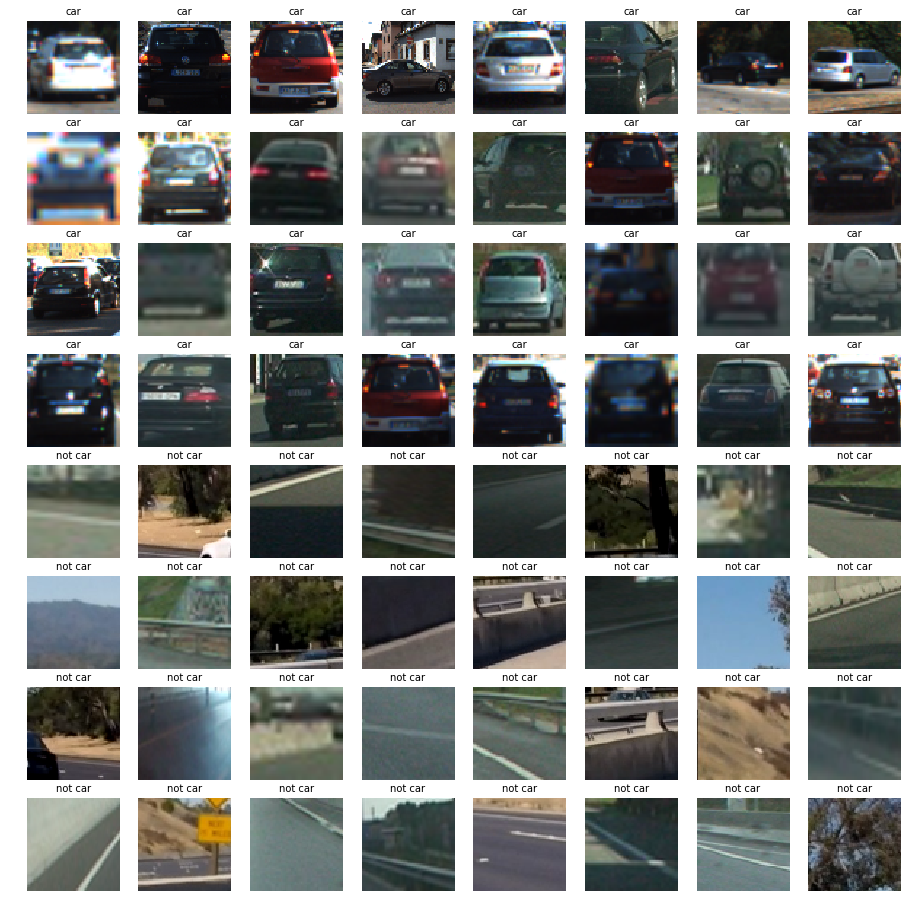

In [49]:
# Visualize some data from dataset

fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(32):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
    
for i in np.arange(32,64):
    img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('not car', fontsize=10)
    axs[i].imshow(img)
    
plt.savefig('output_images/data_visualization.png', 
            bbox_inches="tight")

In [50]:
from tqdm import tqdm

def extract_features(imgs, color_space='RGB', orient=9, 
                    pix_per_cell=8, cell_per_block=2, hog_channel=0, hist_bins = 32 ):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(imgs):
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [51]:
#Hyper parameters

colorspace = 'YUV' #RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11        # HOG orientations
pix_per_cell = 16  # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


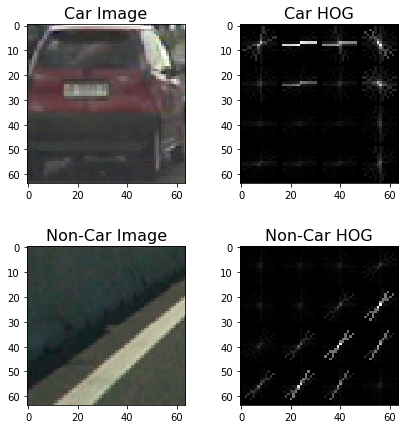

In [52]:
# Visualize HOG example
ind = np.random.randint(0, len(cars))
car_img = mpimg.imread(cars[ind])
_,car_feature = get_hog_features(car_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

ind = np.random.randint(0, len(notcars))
notcar_img = mpimg.imread(notcars[ind])
_,notcar_feature = get_hog_features(notcar_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_feature, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(notcar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(notcar_feature, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

plt.savefig('output_images/hog_visualization.png', 
            bbox_inches="tight")

In [53]:
#Extract features
t1 = time.time()
car_features = extract_features(cars, color_space=colorspace, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

notcar_features = extract_features(notcars, color_space=colorspace, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to extract HOG features')

100%|██████████| 8968/8968 [02:13<00:00, 67.35it/s]

267.43 Seconds to extract HOG features


In [54]:
#Construct features and labels

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [55]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])

2.4 Seconds to train SVC...
Test Accuracy of SVC =  0.984
  Predictions: [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  0.]
       Labels: [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  0.]


In [56]:
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    bboxes = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
             
            hog_features = hog_features.reshape(1, -1)
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale) 
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bboxes

In [57]:
# Read test image
image = mpimg.imread('./test_images/test1.jpg')
draw_img = np.copy(image)

4 rectangles found in image


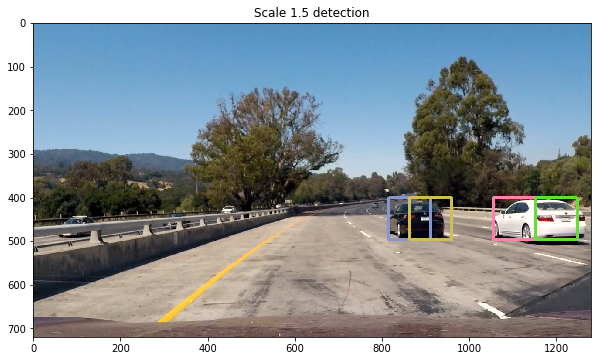

In [59]:
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
scale = 1.5

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

bboxes = find_cars(draw_img, y_start_stop[0], y_start_stop[1], scale, colorspace, hog_channel, svc, 
                   None, orient, pix_per_cell, cell_per_block, None, None)


test_img_rects = draw_boxes(draw_img, bboxes, random_color = True)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.title('Scale 1.5 detection')
plt.savefig('output_images/scale_1_5_detection.png', bbox_inches="tight")

print(len(bboxes), 'rectangles found in image')

In [60]:
#Filtering false positives

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

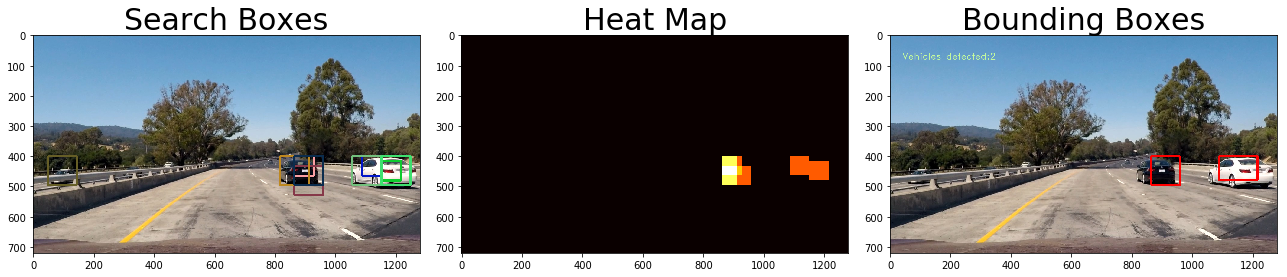

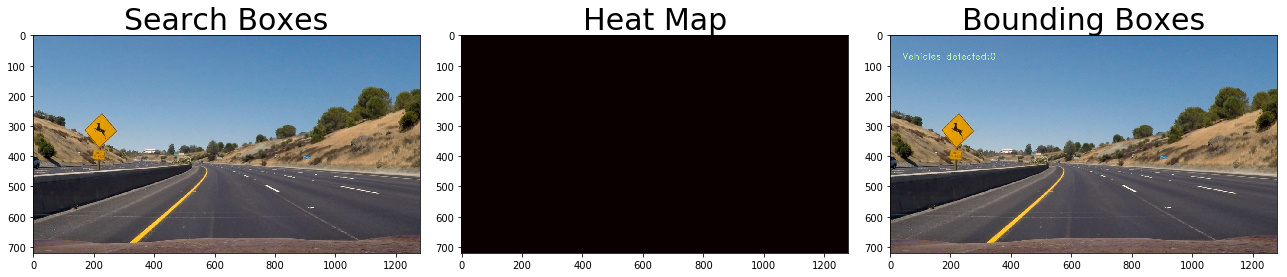

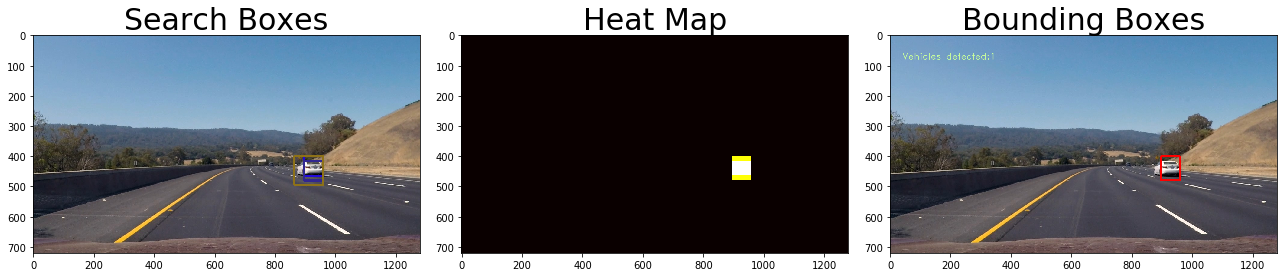

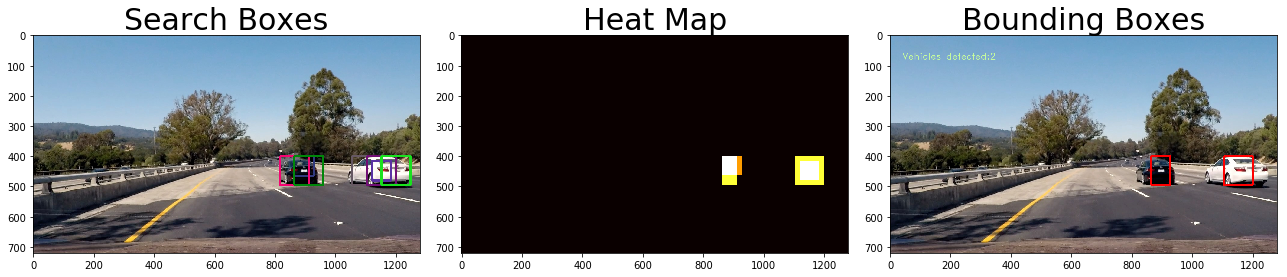

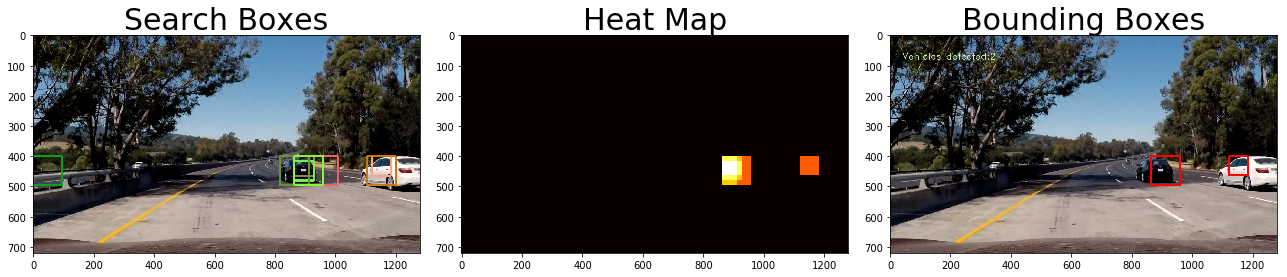

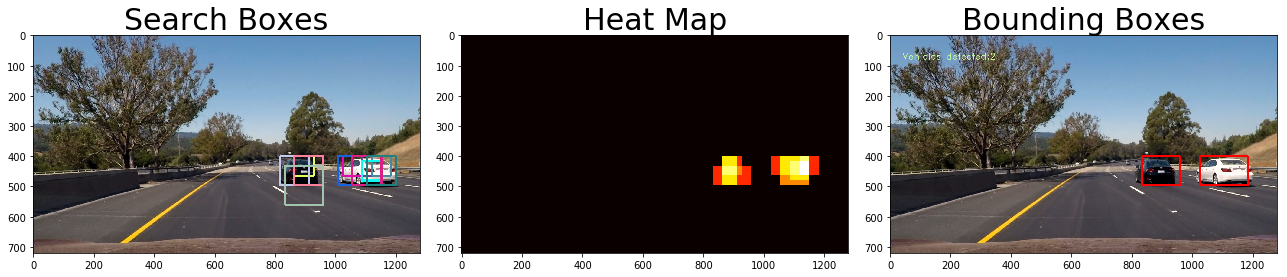

In [61]:
for i in range(1,7):
    
    fname = 'test_images/test{}.jpg'.format(i)
    img = mpimg.imread(fname)
    

    colorspace = 'YUV'
    orient=11
    pix_per_cell=16
    cell_per_block=2
    
    bbox_list = []
 
    ystart = 400
    ystop = 464
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    ystart = 416
    ystop = 480
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    ystart = 400
    ystop = 496
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, None, orient, pix_per_cell, cell_per_block, None, None))
 
    ystart = 432
    ystop = 528
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    ystart = 400
    ystop = 528
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    ystart = 432
    ystop = 560
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    ystart = 400
    ystop = 596
    scale = 3.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    ystart = 464
    ystop = 660
    scale = 3.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    out_img = draw_boxes(img, bbox_list, random_color=True)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 2)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)

    text = 'Vehicles detected:' + str(labels[1])
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(new_img, text, (40,80), font, 1, (200,255,155), 1, cv2.LINE_AA)
        
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(out_img)
    ax1.set_title('Search Boxes', fontsize=30)
    ax2.imshow(heat, cmap='hot')
    ax2.set_title('Heat Map', fontsize=30)
    ax3.imshow(new_img)
    ax3.set_title('Bounding Boxes', fontsize=30)
    
    outname = 'output_images/multiscale_detection_testimg{}.jpg'.format(i)
    plt.savefig(outname, bbox_inches="tight")

In [62]:
# Class to store data from video

class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [63]:
def process_image(img):

    colorspace = 'YUV'
    orient=11
    pix_per_cell=16
    cell_per_block=2
    hog_channel = 'ALL'
    hist_bins = 64
    
    bbox_list = []

    ystart = 400
    ystop = 464
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, None, hist_bins))
    
    ystart = 416
    ystop = 480
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    ystart = 400
    ystop = 496
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, None, orient, pix_per_cell, cell_per_block, None, None))
 
    ystart = 432
    ystop = 528
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    ystart = 400
    ystop = 528
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    ystart = 432
    ystop = 560
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    ystart = 400
    ystop = 596
    scale = 3.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    ystart = 464
    ystop = 660
    scale = 3.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, 
                    svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    empty_box = []
    if len(bbox_list) > 0:
        det.add_rects(bbox_list)
    else:
        det.add_rects(empty_box)  

    heat = np.zeros_like(img[:,:,0])
    for bboxes in det.prev_rects:
        heat = add_heat(heat, bboxes)
        
    heat = apply_threshold(heat,1+ len(det.prev_rects)//2)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)
    
    text = 'Vehicles detected:' + str(labels[1])
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(new_img, text, (40,80), font, 1, (200,255,155), 1, cv2.LINE_AA)
    return new_img

In [64]:
det = Vehicle_Detect()
# Pipeline processing on video
clip_output = "./output_videos/project_output.mp4"
#clip = VideoFileClip("./project_video.mp4").subclip(0,22)
clip = VideoFileClip("./project_video.mp4")
test_clip = clip.fl_image(process_image)
%time test_clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_output.mp4
[MoviePy] Writing video ./output_videos/project_output.mp4


100%|█████████▉| 1260/1261 [14:09<00:00,  1.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_output.mp4 

CPU times: user 8min 35s, sys: 1.82 s, total: 8min 37s
Wall time: 14min 13s


In [65]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_output))